In [1]:
import pandas as pd
import numpy as np
import typing as ty
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset



In [2]:
SEED = 777


torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


np.random.seed(SEED)

In [3]:
df = pd.read_csv('nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []

    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)


def prepare_data_loaders(
    raw_data: pd.DataFrame,
    use_feature_names: ty.List[str],
    batch_size: int = 32,
    window_size: int = 10,
    step: int = 15,
    normalization: str = None) -> ty.Tuple:

    # Select features
    features = df[use_feature_names]
    labels = df['High'].shift(-1)  # Next day's high price as label

    X, y = create_sequences(features, labels, window_size=10, step=15)

    print(f'Shape of data X: {X.shape}')
    print(f'Shape of data y: {y.shape}')

    # split the hold-out tests
    ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
    x_test = X[ind]
    y_test = y[ind]
    all_ind = np.arange(len(X))
    remains_ind = np.delete(all_ind, ind)

    X = X[remains_ind]
    y = y[remains_ind]

    # shuffle dataset
    ind = np.random.permutation(len(X))
    X = X[ind]
    y = y[ind]
    split_point = int(X.shape[0]*0.8)

    x_train = X[:split_point]
    y_train = y[:split_point]
    x_val = X[split_point:]
    y_val = y[split_point:]

    print(f'Shape of data x_train: {x_train.shape}')
    print(f'Shape of data y_train: {y_train.shape}')
    print(f'Shape of data x_val: {x_val.shape}')
    print(f'Shape of data y_val: {y_val.shape}')
    print(f'Shape of data x_test: {x_test.shape}')
    print(f'Shape of data y_test: {y_test.shape}')

    # Apply normalization
    # Labels (y)
    y_scaler = StandardScaler()
    y_train_normalized = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_val_normalized = y_scaler.transform(y_val.reshape(-1, 1)).reshape(-1)
    y_test_normalized = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

    # Features (X)
    if normalization is not None:
        assert normalization in ('minmax', 'std')

        for c in range(X.shape[2]):
            scaler = MinMaxScaler() if normalization == 'minmax' else StandardScaler()
            x_train[:, :, c] = scaler.fit_transform(x_train[:, :, c].reshape(-1, 1)).reshape(-1, window_size)
            x_val[:, :, c] = scaler.transform(x_val[:, :, c].reshape(-1, 1)).reshape(-1, window_size)
            x_test[:, :, c] = scaler.transform(x_test[:, :, c].reshape(-1, 1)).reshape(-1, window_size)

    # Convert to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()
    y_train_normalized = torch.from_numpy(y_train_normalized).float()

    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).float()
    y_val_normalized = torch.from_numpy(y_val_normalized).float()

    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float()
    y_test_normalized = torch.from_numpy(y_test_normalized).float()

    # Create datasets
    train_dataset = TensorDataset(x_train, y_train, y_train_normalized)
    val_dataset = TensorDataset(x_val, y_val, y_val_normalized)
    test_dataset = TensorDataset(x_test, y_test, y_test_normalized)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

    return (train_loader, val_loader, test_loader, y_scaler)


In [5]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
from collections import defaultdict



class LSTMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, output_dim: int) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


def train_one_epoch(
        model: nn.Module,
        loader: DataLoader,
        criterion: ty.Callable,
        optimizer: optim.Optimizer,
        device: str) -> float:

    model.train()
    total_loss = 0.0

    for features, _, labels in loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(loader)

    return avg_train_loss


@torch.no_grad()
def eval_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: ty.Callable,
    y_scaler: StandardScaler,
    device: str) -> float:

    model.eval()
    pred_value = []
    actual_value = []

    for features, labels, _ in loader:
            features = features.to(device)
            outputs = model(features).squeeze(-1).cpu().numpy()
            outputs = y_scaler.inverse_transform(outputs.reshape(-1, 1)).reshape(-1)
            pred_value.append(torch.from_numpy(outputs))
            actual_value.append(labels)

    pred_value = torch.cat(pred_value)
    actual_value = torch.cat(actual_value)
    eval_loss = criterion(pred_value, actual_value)

    return eval_loss.item()


def run_experiment(
    epochs: int,
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    y_scaler: StandardScaler,
    device: str) -> ty.Dict[str, ty.List[float]]:

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

    metrics = defaultdict(list)
    best_val_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        # Training
        _ = train_one_epoch(model, train_loader, criterion, optimizer, device)
        lr_scheduler.step()

        curr_train_loss = eval_one_epoch(model, train_loader, criterion, y_scaler, device)

        # Validation
        curr_val_loss = eval_one_epoch(model, val_loader, criterion, y_scaler, device)

        # Checkpoint
        if curr_val_loss < best_val_loss:
            best_val_loss = curr_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}/{epochs}, Train loss: {curr_train_loss:.4f}, Val loss: {curr_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

        metrics['train_losses'].append(curr_train_loss)
        metrics['val_losses'].append(curr_val_loss)


    # Testing
    model.load_state_dict(torch.load('best_model.pth'))

    test_loss = eval_one_epoch(model, test_loader, criterion, y_scaler, device)
    print(f'test_loss : {test_loss}')

    metrics['test_loss'].append(test_loss)

    return metrics


def find_best_scores(training_losses, validation_losses):
    # Find the index of the best (minimum) validation score
    best_index = validation_losses.index(min(validation_losses))

    # Retrieve the corresponding training and testing scores
    best_training_score = training_losses[best_index]
    best_validation_score = validation_losses[best_index]

    return best_training_score, best_validation_score

## Q1
Train the model using 3 different combinations of window size and step

In [10]:
USE_FEATURE_NAMES = ['Open', 'High', 'Low', 'Close']
HIDDEN_DIM = 500
NUM_LAYERS = 2
BATCH_SIZE = 32
WINDOW_SIZE = 10
STEP = 15
NUM_EPOCHS = 100
DEVICE = 'cpu'


EXP_COMBINATIONS = [
    {'window_size': 10, 'step': 30},
    {'window_size': 10, 'step': 10},
    {'window_size': 30, 'step': 15},
    {'window_size': 20, 'step': 30},
    {'window_size': 30, 'step': 30}

]


model = LSTMModel(
    input_dim=len(USE_FEATURE_NAMES),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=1).to(DEVICE)


results_dict = defaultdict(list)

for combination in EXP_COMBINATIONS:
    print('combination :')
    print(combination)
    window_size = combination['window_size']
    step = combination['step']

    train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, USE_FEATURE_NAMES, BATCH_SIZE, window_size, step)

    metrics = run_experiment(NUM_EPOCHS, model, train_loader, val_loader, test_loader, y_scaler, DEVICE)

    train_loss, val_loss = find_best_scores(metrics['train_losses'], metrics['val_losses'])

    results_dict['window_size'].append(window_size)
    results_dict['step'].append(step)
    results_dict['train_mse'].append(train_loss)
    results_dict['val_mse'].append(val_loss)
    results_dict['test_mse'].append(metrics['test_loss'][0])


results_df = pd.DataFrame(results_dict)
results_df


combination :
{'window_size': 10, 'step': 30}
Shape of data X: (315, 10, 4)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 54.2043, Val loss: 138.7794, Best Val loss: 138.7794
Epoch 2/100, Train loss: 35.9646, Val loss: 51.6111, Best Val loss: 51.6111
Epoch 3/100, Train loss: 17.1024, Val loss: 36.1804, Best Val loss: 36.1804
Epoch 4/100, Train loss: 26.6532, Val loss: 46.8439, Best Val loss: 36.1804
Epoch 5/100, Train loss: 106.4289, Val loss: 211.8559, Best Val loss: 36.1804
Epoch 6/100, Train loss: 51.3350, Val loss: 157.3480, Best Val loss: 36.1804
Epoch 7/100, Train loss: 12.2447, Val loss: 49.6587, Best Val loss: 36.1804
Epoch 8/100, Train loss: 26.4205, Val loss: 33.4522, Best Val loss: 33.4522
Epoch 9/100, Train loss: 9.4023, Val loss: 32.5055, Best Val loss: 32.5055
Epoch 10/100, Train loss: 5.2808, Val loss: 19.6150, Best Val loss: 19.6150
Epoch 11/100, Train loss: 4.0359, Val loss: 14.8225, Best Val loss: 14.8225
Epoch 12/100, Train loss: 2.7977, Val loss: 6.2811, Best Val loss: 6.2811
Epoch 13/100, Train loss: 3.0679, Val loss: 3.6482, Best Val loss: 3.6482
Epoch 14/100

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 10.6493, Val loss: 7.1077, Best Val loss: 7.1077
Epoch 2/100, Train loss: 6.6130, Val loss: 7.5620, Best Val loss: 7.1077
Epoch 3/100, Train loss: 10.3482, Val loss: 13.3374, Best Val loss: 7.1077
Epoch 4/100, Train loss: 10.1509, Val loss: 13.2636, Best Val loss: 7.1077
Epoch 5/100, Train loss: 11.8870, Val loss: 14.6574, Best Val loss: 7.1077
Epoch 6/100, Train loss: 40.2070, Val loss: 19.4045, Best Val loss: 7.1077
Epoch 7/100, Train loss: 20.5219, Val loss: 21.3155, Best Val loss: 7.1077
Epoch 8/100, Train loss: 21.8234, Val loss: 11.7060, Best Val loss: 7.1077
Epoch 9/100, Train loss: 22.0737, Val loss: 25.6725, Best Val loss: 7.1077
Epoch 10/100, Train loss: 25.5075, Val loss: 13.1572, Best Val loss: 7.1077
Epoch 11/100, Train loss: 18.5862, Val loss: 21.9418, Best Val loss: 7.1077
Epoch 12/100, Train loss: 25.7126, Val loss: 10.9073, Best Val loss: 7.1077
Epoch 13/100, Train loss: 8.5095, Val loss: 10.7621, Best Val loss: 7.1077
Epoch 14/100, Train loss:

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 8.6195, Val loss: 4.0791, Best Val loss: 4.0791
Epoch 2/100, Train loss: 10.1449, Val loss: 5.0082, Best Val loss: 4.0791
Epoch 3/100, Train loss: 11.8624, Val loss: 9.4953, Best Val loss: 4.0791
Epoch 4/100, Train loss: 8.9079, Val loss: 3.0246, Best Val loss: 3.0246
Epoch 5/100, Train loss: 6.0550, Val loss: 5.2840, Best Val loss: 3.0246
Epoch 6/100, Train loss: 4.2248, Val loss: 0.8405, Best Val loss: 0.8405
Epoch 7/100, Train loss: 3.5454, Val loss: 3.5157, Best Val loss: 0.8405
Epoch 8/100, Train loss: 2.2921, Val loss: 0.5393, Best Val loss: 0.5393
Epoch 9/100, Train loss: 2.0762, Val loss: 1.4877, Best Val loss: 0.5393
Epoch 10/100, Train loss: 7.7805, Val loss: 1.1472, Best Val loss: 0.5393
Epoch 11/100, Train loss: 21.3013, Val loss: 19.0715, Best Val loss: 0.5393
Epoch 12/100, Train loss: 6.7137, Val loss: 1.7492, Best Val loss: 0.5393
Epoch 13/100, Train loss: 5.2610, Val loss: 4.3357, Best Val loss: 0.5393
Epoch 14/100, Train loss: 10.5733, Val loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 12.4111, Val loss: 2.6039, Best Val loss: 2.6039
Epoch 2/100, Train loss: 7.0954, Val loss: 13.5443, Best Val loss: 2.6039
Epoch 3/100, Train loss: 5.8458, Val loss: 5.4900, Best Val loss: 2.6039
Epoch 4/100, Train loss: 8.2877, Val loss: 9.9559, Best Val loss: 2.6039
Epoch 5/100, Train loss: 3.7298, Val loss: 11.1135, Best Val loss: 2.6039
Epoch 6/100, Train loss: 5.0282, Val loss: 5.5997, Best Val loss: 2.6039
Epoch 7/100, Train loss: 8.8756, Val loss: 9.8069, Best Val loss: 2.6039
Epoch 8/100, Train loss: 5.3490, Val loss: 4.9735, Best Val loss: 2.6039
Epoch 9/100, Train loss: 2.2685, Val loss: 7.9536, Best Val loss: 2.6039
Epoch 10/100, Train loss: 1.8484, Val loss: 4.6652, Best Val loss: 2.6039
Epoch 11/100, Train loss: 1.1299, Val loss: 6.0398, Best Val loss: 2.6039
Epoch 12/100, Train loss: 1.2116, Val loss: 5.8435, Best Val loss: 2.6039
Epoch 13/100, Train loss: 1.1815, Val loss: 5.1686, Best Val loss: 2.6039
Epoch 14/100, Train loss: 1.2231, Val loss: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 26.2676, Val loss: 9.2692, Best Val loss: 9.2692
Epoch 2/100, Train loss: 21.9708, Val loss: 22.8569, Best Val loss: 9.2692
Epoch 3/100, Train loss: 15.4418, Val loss: 13.4759, Best Val loss: 9.2692
Epoch 4/100, Train loss: 9.9598, Val loss: 16.5544, Best Val loss: 9.2692
Epoch 5/100, Train loss: 9.0334, Val loss: 11.9411, Best Val loss: 9.2692
Epoch 6/100, Train loss: 6.3937, Val loss: 13.2453, Best Val loss: 9.2692
Epoch 7/100, Train loss: 2.7304, Val loss: 4.8181, Best Val loss: 4.8181
Epoch 8/100, Train loss: 1.5418, Val loss: 6.9316, Best Val loss: 4.8181
Epoch 9/100, Train loss: 1.0358, Val loss: 6.2602, Best Val loss: 4.8181
Epoch 10/100, Train loss: 1.0205, Val loss: 8.0993, Best Val loss: 4.8181
Epoch 11/100, Train loss: 0.8106, Val loss: 8.4516, Best Val loss: 4.8181
Epoch 12/100, Train loss: 1.1975, Val loss: 9.4184, Best Val loss: 4.8181
Epoch 13/100, Train loss: 3.5461, Val loss: 11.7586, Best Val loss: 4.8181
Epoch 14/100, Train loss: 3.1358, Val 

,window_size,step,train_mse,val_mse,test_mse
0,10,30,2.517504,2.664198,10.708839
1,10,10,3.152644,0.627482,9.582233
2,30,15,2.465711,0.266309,12.031431
3,20,30,17.520016,2.277290,62.389191
4,30,30,2.730360,4.818124,18.909101


## Q2-1
Include 'Volume' as an additional input feature in your model.


Shape of data X: (315, 10, 4)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 163.2716, Val loss: 349.2155, Best Val loss: 349.2155
Epoch 2/100, Train loss: 47.7501, Val loss: 75.8111, Best Val loss: 75.8111
Epoch 3/100, Train loss: 34.9424, Val loss: 46.9328, Best Val loss: 46.9328
Epoch 4/100, Train loss: 21.9554, Val loss: 28.7065, Best Val loss: 28.7065
Epoch 5/100, Train loss: 9.1104, Val loss: 16.2972, Best Val loss: 16.2972
Epoch 6/100, Train loss: 11.8082, Val loss: 36.7715, Best Val loss: 16.2972
Epoch 7/100, Train loss: 3.4628, Val loss: 4.9992, Best Val loss: 4.9992
Epoch 8/100, Train loss: 5.3111, Val loss: 9.8663, Best Val loss: 4.9992
Epoch 9/100, Train loss: 2.6039, Val loss: 4.1251, Best Val loss: 4.1251
Epoch 10/100, Train loss: 2.1525, Val loss: 5.1310, Best Val loss: 4.1251
Epoch 11/100, Train loss: 4.5825, Val loss: 10.2446, Best Val loss: 4.1251
Epoch 12/100, Train loss: 3.2316, Val loss: 6.6285, Best Val loss: 4.1251
Epoch 13/100, Train loss: 12.2253, Val loss: 24.5620, Best Val loss: 4.1251
Epoch 14/100, Train loss

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 913.5475, Val loss: 804.3204, Best Val loss: 804.3204
Epoch 2/100, Train loss: 891.5640, Val loss: 763.7100, Best Val loss: 763.7100
Epoch 3/100, Train loss: 877.5545, Val loss: 756.3146, Best Val loss: 756.3146
Epoch 4/100, Train loss: 878.7958, Val loss: 760.3022, Best Val loss: 756.3146
Epoch 5/100, Train loss: 879.8199, Val loss: 762.0547, Best Val loss: 756.3146
Epoch 6/100, Train loss: 878.9510, Val loss: 755.9398, Best Val loss: 755.9398
Epoch 7/100, Train loss: 883.4285, Val loss: 758.0808, Best Val loss: 755.9398
Epoch 8/100, Train loss: 877.9611, Val loss: 755.9357, Best Val loss: 755.9357
Epoch 9/100, Train loss: 877.8008, Val loss: 756.0156, Best Val loss: 755.9357
Epoch 10/100, Train loss: 877.5593, Val loss: 757.4349, Best Val loss: 755.9357
Epoch 11/100, Train loss: 877.5265, Val loss: 756.3885, Best Val loss: 755.9357
Epoch 12/100, Train loss: 879.4343, Val loss: 761.4182, Best Val loss: 755.9357
Epoch 13/100, Train loss: 878.3370, Val loss: 759

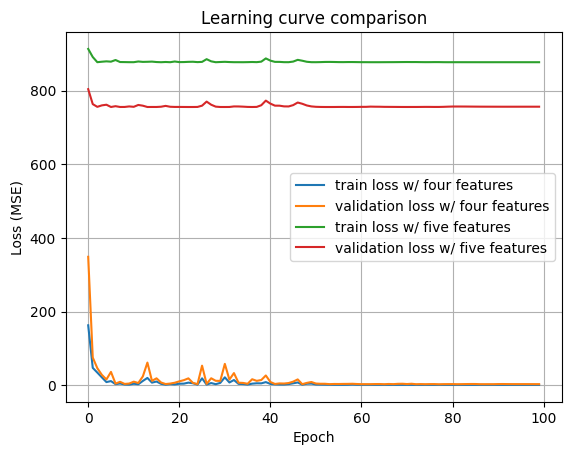

Test loss (w/ four features) : [6.910751819610596]
Test loss (w/ five features) : [1341.9886474609375]


In [7]:
USE_FEATURE_NAMES = ['Open', 'High', 'Low', 'Close', 'Volume']
HIDDEN_DIM = 500
NUM_LAYERS = 2
BATCH_SIZE = 32
WINDOW_SIZE = 10
STEP = 15
NUM_EPOCHS = 100
# DEVICE = 'cpu'

# four features
model = LSTMModel(
    input_dim=len(USE_FEATURE_NAMES[:4]),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=1).to(DEVICE)

train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, USE_FEATURE_NAMES[:4], BATCH_SIZE, WINDOW_SIZE, STEP)

metrics_four_features = run_experiment(
    NUM_EPOCHS, model,
    train_loader, val_loader, test_loader, y_scaler, DEVICE)


# five features
model = LSTMModel(
    input_dim=len(USE_FEATURE_NAMES),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=1).to(DEVICE)

train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, USE_FEATURE_NAMES, BATCH_SIZE, WINDOW_SIZE, STEP)

metrics_five_features = run_experiment(
    NUM_EPOCHS, model,
    train_loader, val_loader, test_loader, y_scaler, DEVICE)


plt.plot(metrics_four_features['train_losses'], label='train loss w/ four features')
plt.plot(metrics_four_features['val_losses'], label='validation loss w/ four features')

plt.plot(metrics_five_features['train_losses'], label='train loss w/ five features')
plt.plot(metrics_five_features['val_losses'], label='validation loss w/ five features')

plt.title('Learning curve comparison')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f'Test loss (w/ four features) : {metrics_four_features["test_loss"]}')
print(f'Test loss (w/ five features) : {metrics_five_features["test_loss"]}')

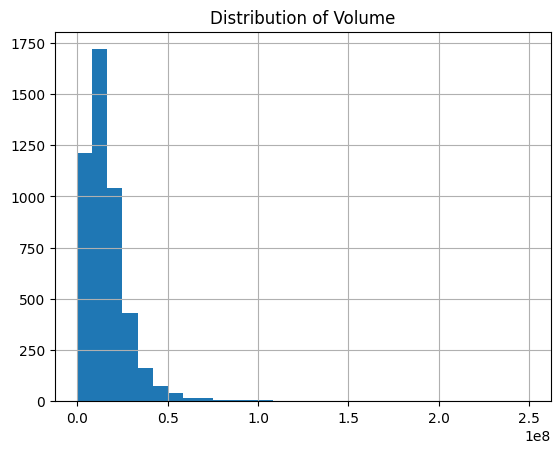

In [13]:
plt.hist(df.Volume, bins=30)
plt.title('Distribution of Volume')
plt.grid()
plt.show()

## Q2-2
Explore and report on the best combination of input features that yields the best MSE

In [16]:
USE_FEATURE_NAMES = ['Open', 'High', 'Low', 'Close', 'Volume']
HIDDEN_DIM = 500
NUM_LAYERS = 2
BATCH_SIZE = 32
WINDOW_SIZE = 10
STEP = 10
NUM_EPOCHS = 100
# DEVICE = 'cpu'


USE_FEATURE_NAMES_COMBINATIONS = [
    ['Open', 'High', 'Low', 'Close', 'Volume'],
    ['Open', 'High', 'Low', 'Close'],
    ['High', 'Low', 'Close', 'Volume'],
    ['Open', 'Low', 'Close', 'Volume'],
    ['Open', 'High', 'Close', 'Volume'],
    ['Open', 'High', 'Low', 'Volume'],
    ['Open'],
    ['High'],
    ['Low'],
    ['Close'],
    ['Volume']
]

results_dict = defaultdict(list)

for use_feature_names in USE_FEATURE_NAMES_COMBINATIONS:

    # four features
    model = LSTMModel(
        input_dim=len(use_feature_names),
        hidden_dim=HIDDEN_DIM,
        num_layers=NUM_LAYERS,
        output_dim=1).to(DEVICE)

    train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, use_feature_names, BATCH_SIZE, WINDOW_SIZE, STEP)

    metrics = run_experiment(
        NUM_EPOCHS, model,
        train_loader, val_loader, test_loader, y_scaler, DEVICE)


    train_loss, val_loss = find_best_scores(metrics['train_losses'], metrics['val_losses'])

    for feature_name in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if feature_name in use_feature_names:
            results_dict[feature_name].append(1)
        else:
            results_dict[feature_name].append(0)

    results_dict['train_mse'].append(train_loss)
    results_dict['val_mse'].append(val_loss)
    results_dict['test_mse'].append(metrics['test_loss'][0])


results_df = pd.DataFrame(results_dict)
results_df


Shape of data X: (315, 10, 5)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 5)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 5)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 5)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 932.0748, Val loss: 688.4131, Best Val loss: 688.4131
Epoch 2/100, Train loss: 930.5820, Val loss: 659.9996, Best Val loss: 659.9996
Epoch 3/100, Train loss: 906.3415, Val loss: 645.9107, Best Val loss: 645.9107
Epoch 4/100, Train loss: 906.2558, Val loss: 651.9662, Best Val loss: 645.9107
Epoch 5/100, Train loss: 905.0230, Val loss: 646.8888, Best Val loss: 645.9107
Epoch 6/100, Train loss: 910.0460, Val loss: 646.8049, Best Val loss: 645.9107
Epoch 7/100, Train loss: 908.4317, Val loss: 646.2131, Best Val loss: 645.9107
Epoch 8/100, Train loss: 905.3618, Val loss: 646.3172, Best Val loss: 645.9107
Epoch 9/100, Train loss: 905.0599, Val loss: 646.7833, Best Val loss: 645.9107
Epoch 10/100, Train loss: 905.8912, Val loss: 646.0030, Best Val loss: 645.9107
Epoch 11/100, Train loss: 906.9435, Val loss: 645.9087, Best Val loss: 645.9087
Epoch 12/100, Train loss: 906.3007, Val loss: 645.9150, Best Val loss: 645.9087
Epoch 13/100, Train loss: 905.0422, Val loss: 648

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 147.0252, Val loss: 92.9588, Best Val loss: 92.9588
Epoch 2/100, Train loss: 114.4877, Val loss: 80.5845, Best Val loss: 80.5845
Epoch 3/100, Train loss: 117.3394, Val loss: 140.0218, Best Val loss: 80.5845
Epoch 4/100, Train loss: 75.2010, Val loss: 62.2422, Best Val loss: 62.2422
Epoch 5/100, Train loss: 36.9336, Val loss: 46.0298, Best Val loss: 46.0298
Epoch 6/100, Train loss: 54.9376, Val loss: 110.3034, Best Val loss: 46.0298
Epoch 7/100, Train loss: 59.2788, Val loss: 46.5214, Best Val loss: 46.0298
Epoch 8/100, Train loss: 18.4914, Val loss: 16.1172, Best Val loss: 16.1172
Epoch 9/100, Train loss: 12.9011, Val loss: 8.4457, Best Val loss: 8.4457
Epoch 10/100, Train loss: 20.3959, Val loss: 23.4944, Best Val loss: 8.4457
Epoch 11/100, Train loss: 14.0722, Val loss: 18.8686, Best Val loss: 8.4457
Epoch 12/100, Train loss: 6.1475, Val loss: 4.0866, Best Val loss: 4.0866
Epoch 13/100, Train loss: 3.4605, Val loss: 3.9611, Best Val loss: 3.9611
Epoch 14/100,

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 840.6686, Val loss: 1224.7152, Best Val loss: 1224.7152
Epoch 2/100, Train loss: 760.4039, Val loss: 1256.0424, Best Val loss: 1224.7152
Epoch 3/100, Train loss: 767.5439, Val loss: 1214.7711, Best Val loss: 1214.7711
Epoch 4/100, Train loss: 760.6896, Val loss: 1223.2587, Best Val loss: 1214.7711
Epoch 5/100, Train loss: 758.2988, Val loss: 1242.9027, Best Val loss: 1214.7711
Epoch 6/100, Train loss: 761.3551, Val loss: 1259.9874, Best Val loss: 1214.7711
Epoch 7/100, Train loss: 759.5390, Val loss: 1251.8585, Best Val loss: 1214.7711
Epoch 8/100, Train loss: 758.2620, Val loss: 1242.4420, Best Val loss: 1214.7711
Epoch 9/100, Train loss: 758.0921, Val loss: 1239.2189, Best Val loss: 1214.7711
Epoch 10/100, Train loss: 762.0927, Val loss: 1220.5923, Best Val loss: 1214.7711
Epoch 11/100, Train loss: 758.0778, Val loss: 1238.5562, Best Val loss: 1214.7711
Epoch 12/100, Train loss: 760.9412, Val loss: 1258.3328, Best Val loss: 1214.7711
Epoch 13/100, Train loss:

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 930.0594, Val loss: 682.7158, Best Val loss: 682.7158
Epoch 2/100, Train loss: 940.3420, Val loss: 639.4376, Best Val loss: 639.4376
Epoch 3/100, Train loss: 908.0055, Val loss: 635.6975, Best Val loss: 635.6975
Epoch 4/100, Train loss: 908.3220, Val loss: 639.7432, Best Val loss: 635.6975
Epoch 5/100, Train loss: 908.4117, Val loss: 640.2081, Best Val loss: 635.6975
Epoch 6/100, Train loss: 910.8228, Val loss: 647.9377, Best Val loss: 635.6975
Epoch 7/100, Train loss: 908.3476, Val loss: 639.8811, Best Val loss: 635.6975
Epoch 8/100, Train loss: 908.2171, Val loss: 634.1618, Best Val loss: 634.1618
Epoch 9/100, Train loss: 908.2183, Val loss: 634.1568, Best Val loss: 634.1568
Epoch 10/100, Train loss: 908.5032, Val loss: 633.2198, Best Val loss: 633.2198
Epoch 11/100, Train loss: 908.2251, Val loss: 634.1273, Best Val loss: 633.2198
Epoch 12/100, Train loss: 908.3387, Val loss: 639.8332, Best Val loss: 633.2198
Epoch 13/100, Train loss: 916.1517, Val loss: 659

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 856.6707, Val loss: 862.6735, Best Val loss: 862.6735
Epoch 2/100, Train loss: 861.2634, Val loss: 865.5692, Best Val loss: 862.6735
Epoch 3/100, Train loss: 858.0011, Val loss: 864.1005, Best Val loss: 862.6735
Epoch 4/100, Train loss: 854.7382, Val loss: 860.5703, Best Val loss: 860.5703
Epoch 5/100, Train loss: 854.5527, Val loss: 860.3655, Best Val loss: 860.3655
Epoch 6/100, Train loss: 852.3652, Val loss: 857.8203, Best Val loss: 857.8203
Epoch 7/100, Train loss: 852.4570, Val loss: 857.9418, Best Val loss: 857.8203
Epoch 8/100, Train loss: 852.1782, Val loss: 857.4230, Best Val loss: 857.4230
Epoch 9/100, Train loss: 853.0408, Val loss: 858.6538, Best Val loss: 857.4230
Epoch 10/100, Train loss: 852.5475, Val loss: 858.0574, Best Val loss: 857.4230
Epoch 11/100, Train loss: 852.7943, Val loss: 858.3607, Best Val loss: 857.4230
Epoch 12/100, Train loss: 854.0020, Val loss: 859.7523, Best Val loss: 857.4230
Epoch 13/100, Train loss: 854.5480, Val loss: 860

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 782.1224, Val loss: 1194.0231, Best Val loss: 1194.0231
Epoch 2/100, Train loss: 785.5952, Val loss: 1238.0792, Best Val loss: 1194.0231
Epoch 3/100, Train loss: 768.1585, Val loss: 1193.8214, Best Val loss: 1193.8214
Epoch 4/100, Train loss: 767.1212, Val loss: 1196.0763, Best Val loss: 1193.8214
Epoch 5/100, Train loss: 767.1901, Val loss: 1200.8877, Best Val loss: 1193.8214
Epoch 6/100, Train loss: 769.1733, Val loss: 1192.9174, Best Val loss: 1192.9174
Epoch 7/100, Train loss: 767.1012, Val loss: 1196.1703, Best Val loss: 1192.9174
Epoch 8/100, Train loss: 767.9396, Val loss: 1204.0657, Best Val loss: 1192.9174
Epoch 9/100, Train loss: 769.5871, Val loss: 1208.7938, Best Val loss: 1192.9174
Epoch 10/100, Train loss: 767.1700, Val loss: 1200.7699, Best Val loss: 1192.9174
Epoch 11/100, Train loss: 767.9753, Val loss: 1194.0616, Best Val loss: 1192.9174
Epoch 12/100, Train loss: 767.1966, Val loss: 1195.7666, Best Val loss: 1192.9174
Epoch 13/100, Train loss:

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 181.4739, Val loss: 292.2690, Best Val loss: 292.2690
Epoch 2/100, Train loss: 74.8791, Val loss: 56.3283, Best Val loss: 56.3283
Epoch 3/100, Train loss: 51.1308, Val loss: 67.5805, Best Val loss: 56.3283
Epoch 4/100, Train loss: 91.7251, Val loss: 87.2661, Best Val loss: 56.3283
Epoch 5/100, Train loss: 27.2509, Val loss: 40.6185, Best Val loss: 40.6185
Epoch 6/100, Train loss: 12.1366, Val loss: 15.9476, Best Val loss: 15.9476
Epoch 7/100, Train loss: 8.3985, Val loss: 7.8521, Best Val loss: 7.8521
Epoch 8/100, Train loss: 5.2212, Val loss: 5.4914, Best Val loss: 5.4914
Epoch 9/100, Train loss: 3.9455, Val loss: 2.9608, Best Val loss: 2.9608
Epoch 10/100, Train loss: 3.3747, Val loss: 2.0958, Best Val loss: 2.0958
Epoch 11/100, Train loss: 2.9373, Val loss: 2.4032, Best Val loss: 2.0958
Epoch 12/100, Train loss: 3.8615, Val loss: 4.8784, Best Val loss: 2.0958
Epoch 13/100, Train loss: 2.9307, Val loss: 2.7096, Best Val loss: 2.0958
Epoch 14/100, Train loss: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 191.7828, Val loss: 55.6342, Best Val loss: 55.6342
Epoch 2/100, Train loss: 78.2343, Val loss: 55.8285, Best Val loss: 55.6342
Epoch 3/100, Train loss: 47.2405, Val loss: 16.0016, Best Val loss: 16.0016
Epoch 4/100, Train loss: 20.7847, Val loss: 12.8056, Best Val loss: 12.8056
Epoch 5/100, Train loss: 9.8932, Val loss: 1.8918, Best Val loss: 1.8918
Epoch 6/100, Train loss: 10.9478, Val loss: 4.2840, Best Val loss: 1.8918
Epoch 7/100, Train loss: 5.5204, Val loss: 2.8923, Best Val loss: 1.8918
Epoch 8/100, Train loss: 14.8015, Val loss: 6.8712, Best Val loss: 1.8918
Epoch 9/100, Train loss: 10.0861, Val loss: 6.7035, Best Val loss: 1.8918
Epoch 10/100, Train loss: 4.6733, Val loss: 1.8199, Best Val loss: 1.8199
Epoch 11/100, Train loss: 7.4002, Val loss: 1.4731, Best Val loss: 1.4731
Epoch 12/100, Train loss: 10.6683, Val loss: 3.4929, Best Val loss: 1.4731
Epoch 13/100, Train loss: 6.5748, Val loss: 1.1369, Best Val loss: 1.1369
Epoch 14/100, Train loss: 5.97

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 99.3572, Val loss: 230.3135, Best Val loss: 230.3135
Epoch 2/100, Train loss: 66.5440, Val loss: 49.5972, Best Val loss: 49.5972
Epoch 3/100, Train loss: 50.1602, Val loss: 158.7526, Best Val loss: 49.5972
Epoch 4/100, Train loss: 23.3984, Val loss: 47.7279, Best Val loss: 47.7279
Epoch 5/100, Train loss: 122.7578, Val loss: 166.9440, Best Val loss: 47.7279
Epoch 6/100, Train loss: 46.5028, Val loss: 103.6902, Best Val loss: 47.7279
Epoch 7/100, Train loss: 23.0513, Val loss: 61.1198, Best Val loss: 47.7279
Epoch 8/100, Train loss: 15.2606, Val loss: 39.6481, Best Val loss: 39.6481
Epoch 9/100, Train loss: 6.4074, Val loss: 27.0769, Best Val loss: 27.0769
Epoch 10/100, Train loss: 3.0770, Val loss: 10.8434, Best Val loss: 10.8434
Epoch 11/100, Train loss: 2.4652, Val loss: 16.0505, Best Val loss: 10.8434
Epoch 12/100, Train loss: 1.6561, Val loss: 12.3252, Best Val loss: 10.8434
Epoch 13/100, Train loss: 1.2176, Val loss: 9.7047, Best Val loss: 9.7047
Epoch 14/

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 132.4994, Val loss: 97.1018, Best Val loss: 97.1018
Epoch 2/100, Train loss: 203.5811, Val loss: 128.3182, Best Val loss: 97.1018
Epoch 3/100, Train loss: 69.6561, Val loss: 38.0077, Best Val loss: 38.0077
Epoch 4/100, Train loss: 47.0660, Val loss: 19.4691, Best Val loss: 19.4691
Epoch 5/100, Train loss: 19.0575, Val loss: 6.0314, Best Val loss: 6.0314
Epoch 6/100, Train loss: 7.7759, Val loss: 6.6122, Best Val loss: 6.0314
Epoch 7/100, Train loss: 3.8810, Val loss: 10.0823, Best Val loss: 6.0314
Epoch 8/100, Train loss: 2.1177, Val loss: 9.3052, Best Val loss: 6.0314
Epoch 9/100, Train loss: 8.5840, Val loss: 3.8077, Best Val loss: 3.8077
Epoch 10/100, Train loss: 7.8353, Val loss: 6.1509, Best Val loss: 3.8077
Epoch 11/100, Train loss: 10.1555, Val loss: 16.5161, Best Val loss: 3.8077
Epoch 12/100, Train loss: 10.4920, Val loss: 8.2672, Best Val loss: 3.8077
Epoch 13/100, Train loss: 5.1172, Val loss: 11.9178, Best Val loss: 3.8077
Epoch 14/100, Train loss: 

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 930.1370, Val loss: 664.3235, Best Val loss: 664.3235
Epoch 2/100, Train loss: 941.1185, Val loss: 638.9236, Best Val loss: 638.9236
Epoch 3/100, Train loss: 910.0853, Val loss: 626.7150, Best Val loss: 626.7150
Epoch 4/100, Train loss: 912.4050, Val loss: 636.0266, Best Val loss: 626.7150
Epoch 5/100, Train loss: 909.9731, Val loss: 627.3755, Best Val loss: 626.7150
Epoch 6/100, Train loss: 923.8821, Val loss: 655.3230, Best Val loss: 626.7150
Epoch 7/100, Train loss: 948.5413, Val loss: 688.9351, Best Val loss: 626.7150
Epoch 8/100, Train loss: 945.0431, Val loss: 684.3961, Best Val loss: 626.7150
Epoch 9/100, Train loss: 911.1332, Val loss: 633.0256, Best Val loss: 626.7150
Epoch 10/100, Train loss: 912.8998, Val loss: 624.6606, Best Val loss: 624.6606
Epoch 11/100, Train loss: 914.4639, Val loss: 624.7551, Best Val loss: 624.6606
Epoch 12/100, Train loss: 913.0385, Val loss: 624.6553, Best Val loss: 624.6553
Epoch 13/100, Train loss: 911.4017, Val loss: 625

,Open,High,Low,Close,Volume,train_mse,val_mse,test_mse
0,1,1,1,1,1,906.599548,645.896667,[1343.4903564453125]
1,1,1,1,1,0,1.957497,2.366580,[13.354578018188477]
2,0,1,1,1,1,769.307129,1213.651855,[1332.3248291015625]
3,1,0,1,1,1,911.367676,630.311951,[1345.5150146484375]
4,1,1,0,1,1,852.178162,857.423035,[1337.04248046875]
5,1,1,1,0,1,774.529480,1192.062256,[1332.326904296875]
6,1,0,0,0,0,2.550684,1.818916,[8.062844276428223]
7,0,1,0,0,0,2.580287,0.529858,[4.949810028076172]
8,0,0,1,0,0,1.182933,6.881861,[10.401204109191895]
9,0,0,0,1,0,15.964541,3.206854,[40.11531448364258]


## Q3:
Analyze the performance of the model with and without normalized inputs in Lab 4

Shape of data X: (315, 10, 4)
Shape of data y: (315,)
Shape of data x_train: (227, 10, 4)
Shape of data y_train: (227,)
Shape of data x_val: (57, 10, 4)
Shape of data y_val: (57,)
Shape of data x_test: (31, 10, 4)
Shape of data y_test: (31,)
Number of samples in training and validation are 227 and 57.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 64.4501, Val loss: 47.5833, Best Val loss: 47.5833
Epoch 2/100, Train loss: 23.6737, Val loss: 19.5518, Best Val loss: 19.5518
Epoch 3/100, Train loss: 45.7585, Val loss: 31.0466, Best Val loss: 19.5518
Epoch 4/100, Train loss: 50.1345, Val loss: 28.7402, Best Val loss: 19.5518
Epoch 5/100, Train loss: 33.0300, Val loss: 22.4356, Best Val loss: 19.5518
Epoch 6/100, Train loss: 22.1121, Val loss: 15.2615, Best Val loss: 15.2615
Epoch 7/100, Train loss: 10.5252, Val loss: 7.9453, Best Val loss: 7.9453
Epoch 8/100, Train loss: 9.1755, Val loss: 5.0352, Best Val loss: 5.0352
Epoch 9/100, Train loss: 62.2645, Val loss: 39.7791, Best Val loss: 5.0352
Epoch 10/100, Train loss: 31.2170, Val loss: 22.8865, Best Val loss: 5.0352
Epoch 11/100, Train loss: 11.3005, Val loss: 9.3293, Best Val loss: 5.0352
Epoch 12/100, Train loss: 7.8326, Val loss: 6.1009, Best Val loss: 5.0352
Epoch 13/100, Train loss: 7.4730, Val loss: 4.1251, Best Val loss: 4.1251
Epoch 14/100, Train los

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 399.8523, Val loss: 389.5888, Best Val loss: 389.5888
Epoch 2/100, Train loss: 105.8779, Val loss: 95.6407, Best Val loss: 95.6407
Epoch 3/100, Train loss: 27.0872, Val loss: 24.6737, Best Val loss: 24.6737
Epoch 4/100, Train loss: 25.6891, Val loss: 30.2465, Best Val loss: 24.6737
Epoch 5/100, Train loss: 13.8153, Val loss: 14.5968, Best Val loss: 14.5968
Epoch 6/100, Train loss: 11.5129, Val loss: 11.9131, Best Val loss: 11.9131
Epoch 7/100, Train loss: 10.7688, Val loss: 8.7743, Best Val loss: 8.7743
Epoch 8/100, Train loss: 7.4761, Val loss: 9.1649, Best Val loss: 8.7743
Epoch 9/100, Train loss: 10.1873, Val loss: 7.4858, Best Val loss: 7.4858
Epoch 10/100, Train loss: 8.1383, Val loss: 10.9534, Best Val loss: 7.4858
Epoch 11/100, Train loss: 5.6175, Val loss: 3.8489, Best Val loss: 3.8489
Epoch 12/100, Train loss: 12.5210, Val loss: 8.7860, Best Val loss: 3.8489
Epoch 13/100, Train loss: 27.8046, Val loss: 40.8402, Best Val loss: 3.8489
Epoch 14/100, Train

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 68.1266, Val loss: 16.3117, Best Val loss: 16.3117
Epoch 2/100, Train loss: 35.6905, Val loss: 27.2558, Best Val loss: 16.3117
Epoch 3/100, Train loss: 23.7791, Val loss: 12.5974, Best Val loss: 12.5974
Epoch 4/100, Train loss: 24.3579, Val loss: 8.0748, Best Val loss: 8.0748
Epoch 5/100, Train loss: 43.2020, Val loss: 29.9941, Best Val loss: 8.0748
Epoch 6/100, Train loss: 7.0610, Val loss: 2.9003, Best Val loss: 2.9003
Epoch 7/100, Train loss: 10.0884, Val loss: 5.8245, Best Val loss: 2.9003
Epoch 8/100, Train loss: 32.2526, Val loss: 21.9355, Best Val loss: 2.9003
Epoch 9/100, Train loss: 125.8006, Val loss: 63.2616, Best Val loss: 2.9003
Epoch 10/100, Train loss: 41.1475, Val loss: 32.9229, Best Val loss: 2.9003
Epoch 11/100, Train loss: 15.7262, Val loss: 7.6634, Best Val loss: 2.9003
Epoch 12/100, Train loss: 9.0282, Val loss: 1.9815, Best Val loss: 1.9815
Epoch 13/100, Train loss: 6.6240, Val loss: 4.0095, Best Val loss: 1.9815
Epoch 14/100, Train loss: 

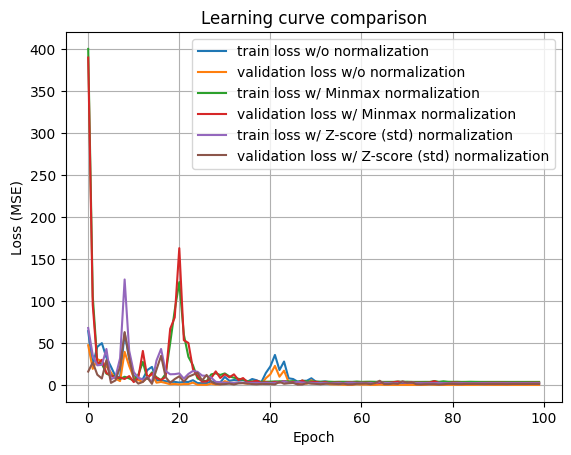

Test loss (w/o normalization) : [11.06159496307373]
Test loss (w/ Minmax) : [11.741545677185059]
Test loss (w/ Z-scpre) : [8.804481506347656]


In [11]:
USE_FEATURE_NAMES = ['Open', 'High', 'Low', 'Close', 'Volume']
HIDDEN_DIM = 500
NUM_LAYERS = 2
BATCH_SIZE = 32
WINDOW_SIZE = 10
STEP = 15
NUM_EPOCHS = 100
# DEVICE = 'cpu'

# W/O Normalization
model = LSTMModel(
    input_dim=len(USE_FEATURE_NAMES),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=1).to(DEVICE)

train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, USE_FEATURE_NAMES[:4], BATCH_SIZE, WINDOW_SIZE, STEP)

metrics_without_normalization = run_experiment(
    NUM_EPOCHS, model,
    train_loader, val_loader, test_loader, y_scaler, DEVICE)


# Apply Minmax
model = LSTMModel(
    input_dim=len(USE_FEATURE_NAMES),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=1).to(DEVICE)

train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, USE_FEATURE_NAMES, BATCH_SIZE, WINDOW_SIZE, STEP, 'minmax')

metrics_with_minmax = run_experiment(
    NUM_EPOCHS, model,
    train_loader, val_loader, test_loader, y_scaler, DEVICE)


# Apply Z-score (std)
model = LSTMModel(
    input_dim=len(USE_FEATURE_NAMES),
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    output_dim=1).to(DEVICE)

train_loader, val_loader, test_loader, y_scaler = \
        prepare_data_loaders(df, USE_FEATURE_NAMES, BATCH_SIZE, WINDOW_SIZE, STEP, 'std')

metrics_with_std = run_experiment(
    NUM_EPOCHS, model,
    train_loader, val_loader, test_loader, y_scaler, DEVICE)



plt.plot(metrics_without_normalization['train_losses'], label='train loss w/o normalization')
plt.plot(metrics_without_normalization['val_losses'], label='validation loss w/o normalization')

plt.plot(metrics_with_minmax['train_losses'], label='train loss w/ Minmax normalization')
plt.plot(metrics_with_minmax['val_losses'], label='validation loss w/ Minmax normalization')

plt.plot(metrics_with_std['train_losses'], label='train loss w/ Z-score (std) normalization')
plt.plot(metrics_with_std['val_losses'], label='validation loss w/ Z-score (std) normalization')

plt.title('Learning curve comparison')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


print(f'Test loss (w/o normalization) : {metrics_without_normalization["test_loss"]}')
print(f'Test loss (w/ Minmax) : {metrics_with_minmax["test_loss"]}')
print(f'Test loss (w/ Z-scpre) : {metrics_with_std["test_loss"]}')